## TW8: Neural Networks

### Set up

In [134]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_blobs

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "NN"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility functions

In [135]:
def plot_class_regions_for_classifier_subplot(clf, X, y, X_test, y_test, title, subplot, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)

    if plot_decision_regions:
        subplot.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    subplot.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    subplot.set_xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    subplot.set_ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        subplot.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    subplot.set_title(title)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        subplot.legend(loc=0, handles=legend_handles)


def plot_class_regions_for_classifier(clf, X, y, X_test=None, 
                                      y_test=None, title=None, target_names = None, plot_decision_regions = True):

    numClasses = np.amax(y) + 1
    color_list_light = ['#FFFFAA', '#EFEFEF', '#AAFFAA', '#AAAAFF']
    color_list_bold = ['#EEEE00', '#000000', '#00CC00', '#0000CC']
    cmap_light = ListedColormap(color_list_light[0:numClasses])
    cmap_bold  = ListedColormap(color_list_bold[0:numClasses])

    h = 0.03
    k = 0.5
    x_plot_adjust = 0.1
    y_plot_adjust = 0.1
    plot_symbol_size = 50

    x_min = X[:, 0].min()
    x_max = X[:, 0].max()
    y_min = X[:, 1].min()
    y_max = X[:, 1].max()
    x2, y2 = np.meshgrid(np.arange(x_min-k, x_max+k, h), np.arange(y_min-k, y_max+k, h))

    P = clf.predict(np.c_[x2.ravel(), y2.ravel()])
    P = P.reshape(x2.shape)
    plt.figure()
    if plot_decision_regions:
        plt.contourf(x2, y2, P, cmap=cmap_light, alpha = 0.8)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=plot_symbol_size, edgecolor = 'black')
    plt.xlim(x_min - x_plot_adjust, x_max + x_plot_adjust)
    plt.ylim(y_min - y_plot_adjust, y_max + y_plot_adjust)

    if (X_test is not None):
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, s=plot_symbol_size, marker='^', edgecolor = 'black')
        train_score = clf.score(X, y)
        test_score  = clf.score(X_test, y_test)
        title = title + "\nTrain score = {:.2f}, Test score = {:.2f}".format(train_score, test_score)

    if (target_names is not None):
        legend_handles = []
        for i in range(0, len(target_names)):
            patch = mpatches.Patch(color=color_list_bold[i], label=target_names[i])
            legend_handles.append(patch)
        plt.legend(loc=0, handles=legend_handles)

    if (title is not None):
        plt.title(title)
    plt.show()
    

## Part 0

### Neural networks: Classification


- We will work on some of cells togeter

- Understand the results

### Activation functions

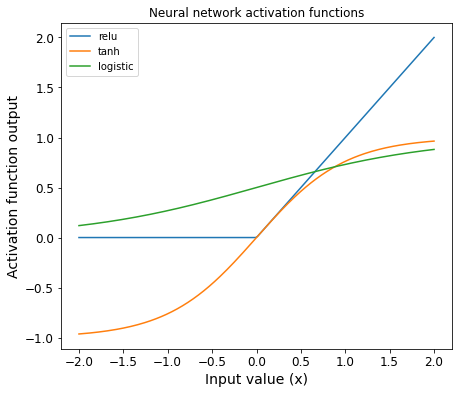

In [136]:
xrange = np.linspace(-2, 2, 200)

plt.figure(figsize=(7,6))

plt.plot(xrange, np.maximum(xrange, 0), label = 'relu')
plt.plot(xrange, np.tanh(xrange), label = 'tanh')
plt.plot(xrange, 1 / (1 + np.exp(-xrange)), label = 'logistic')
plt.legend()
plt.title('Neural network activation functions')
plt.xlabel('Input value (x)')
plt.ylabel('Activation function output')

plt.show()

### Synthetic dataset 1: single hidden layer

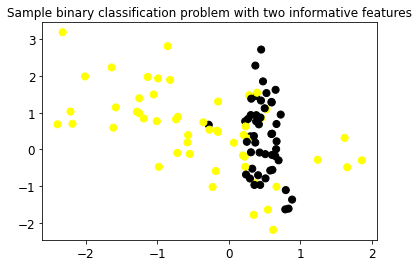

In [137]:
# synthetic dataset for classification (binary)
plt.figure()
plt.title('Sample binary classification problem with two informative features')
X_C2, y_C2 = make_classification(n_samples = 100, n_features=2,
                                n_redundant=0, n_informative=2,
                                n_clusters_per_class=1, flip_y = 0.1,
                                class_sep = 0.5, random_state=0)

plt.scatter(X_C2[:, 0], X_C2[:, 1], marker= 'o', c=y_C2, s=50, cmap=cmap_bold)
plt.show()

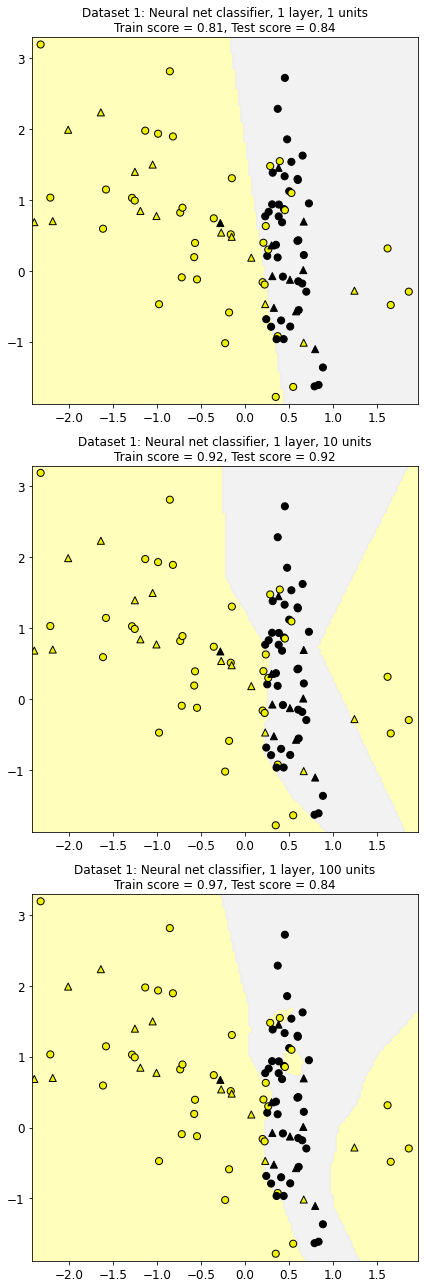

In [138]:
from sklearn.neural_network import MLPClassifier


fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

X_train, X_test, y_train, y_test = train_test_split(X_C2, y_C2, random_state=0)


for units, axis in zip([1, 10, 100], subaxes):
    
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs',
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Synthetic dataset 2: single hidden layer

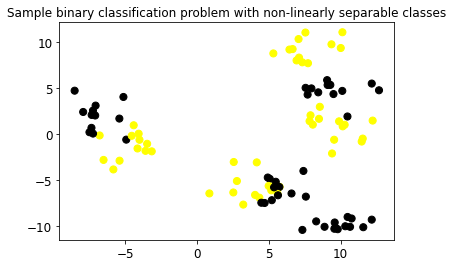

In [139]:
# more difficult synthetic dataset for classification (binary)
# with classes that are not linearly separable
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2,
                       centers = 8, cluster_std = 1.3,
                       random_state = 4)
y_D2 = y_D2 % 2
plt.figure()
plt.title('Sample binary classification problem with non-linearly separable classes')
plt.scatter(X_D2[:,0], X_D2[:,1], c=y_D2,
           marker= 'o', s=50, cmap=cmap_bold)
plt.show()

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


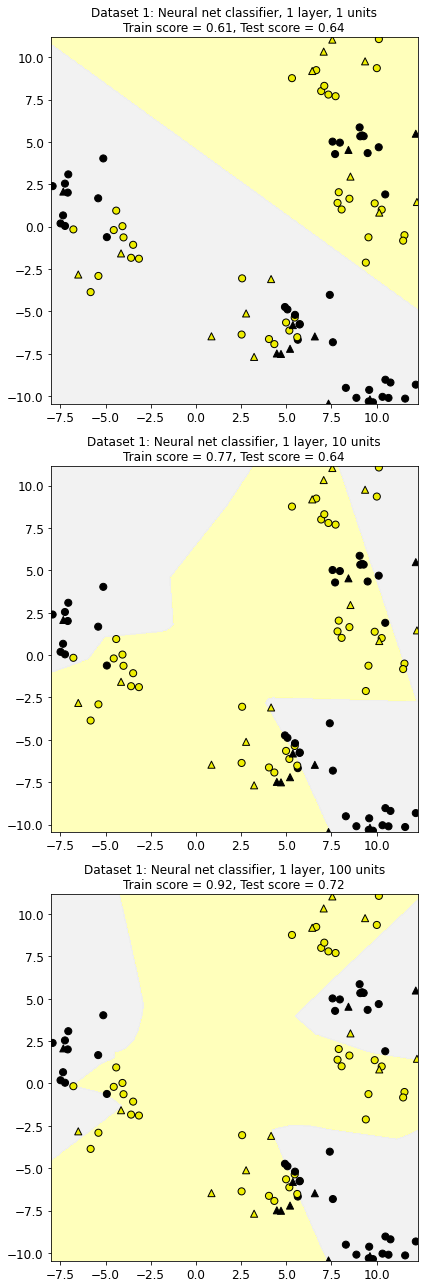

In [140]:
from sklearn.neural_network import MLPClassifier

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)


for units, axis in zip([1, 10, 100], subaxes):
    nnclf = MLPClassifier(hidden_layer_sizes = [units], solver='lbfgs',
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 1: Neural net classifier, 1 layer, {} units'.format(units)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Synthetic dataset 2: two hidden layers

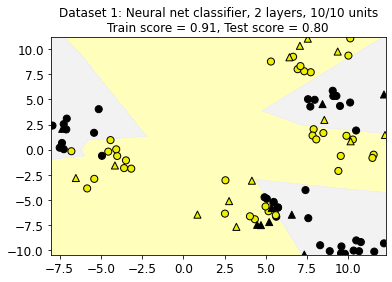

In [141]:
#from adspy_shared_utilities import plot_class_regions_for_classifier

X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

# model training with two hidden layers
nnclf = MLPClassifier(hidden_layer_sizes = [10, 10], solver='lbfgs',
                     random_state = 0).fit(X_train, y_train)

plot_class_regions_for_classifier(nnclf, X_train, y_train, X_test, y_test,
                                 'Dataset 1: Neural net classifier, 2 layers, 10/10 units')

#### Regularization parameter: alpha

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

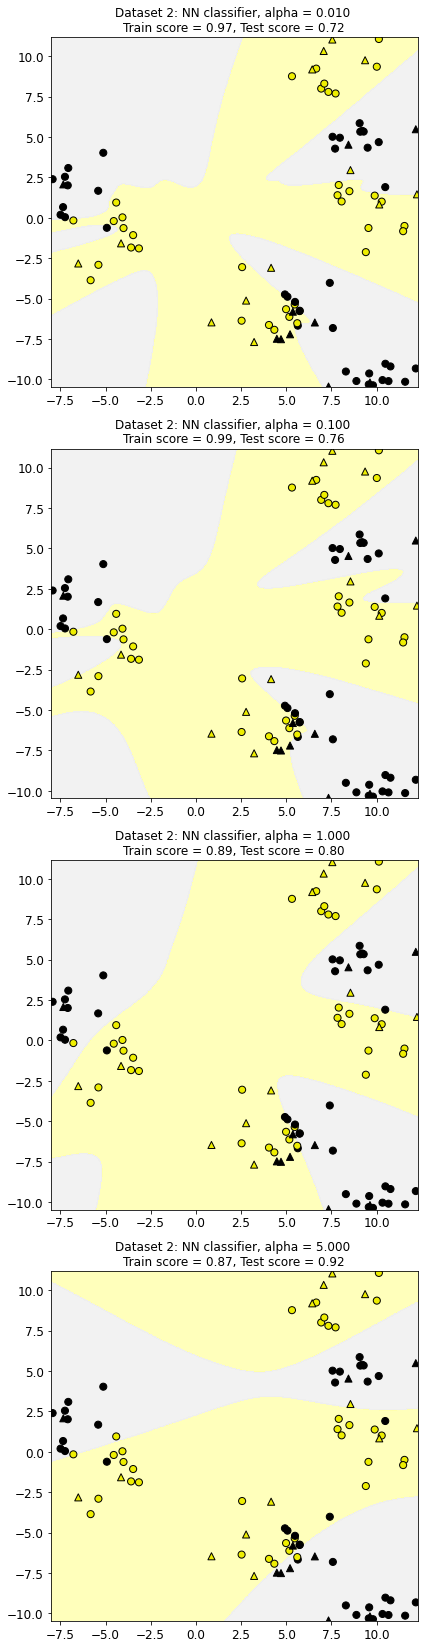

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, alpha = {:.3f} '.format(this_alpha)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()
    

In [143]:
X_train.shape

(75, 2)

#### The effect of different choices of activation function

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

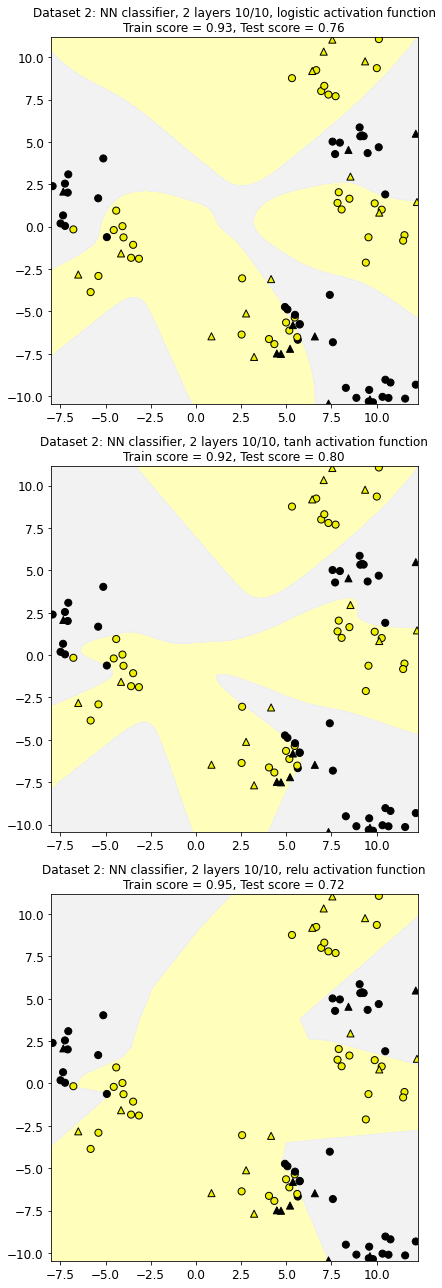

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_D2, y_D2, random_state=0)

fig, subaxes = plt.subplots(3, 1, figsize=(6,18))

for this_activation, axis in zip(['logistic', 'tanh', 'relu'], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = this_activation,
                         alpha = 0.1, hidden_layer_sizes = [10, 10],
                         random_state = 0).fit(X_train, y_train)
    
    title = 'Dataset 2: NN classifier, 2 layers 10/10, {} \
activation function'.format(this_activation)
    
    plot_class_regions_for_classifier_subplot(nnclf, X_train, y_train,
                                             X_test, y_test, title, axis)
    plt.tight_layout()

### Neural networks: Regression

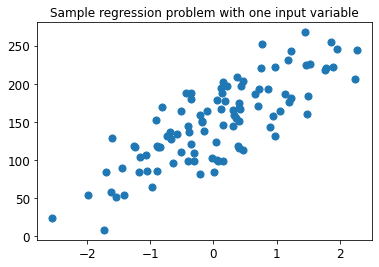

In [145]:
# synthetic dataset for simple regression
from sklearn.datasets import make_regression

plt.figure()
plt.title('Sample regression problem with one input variable')
X_R1, y_R1 = make_regression(n_samples = 100, n_features=1,
                            n_informative=1, bias = 150.0,
                            noise = 30, random_state=0)
plt.scatter(X_R1, y_R1, marker= 'o', s=50)
plt.show()

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

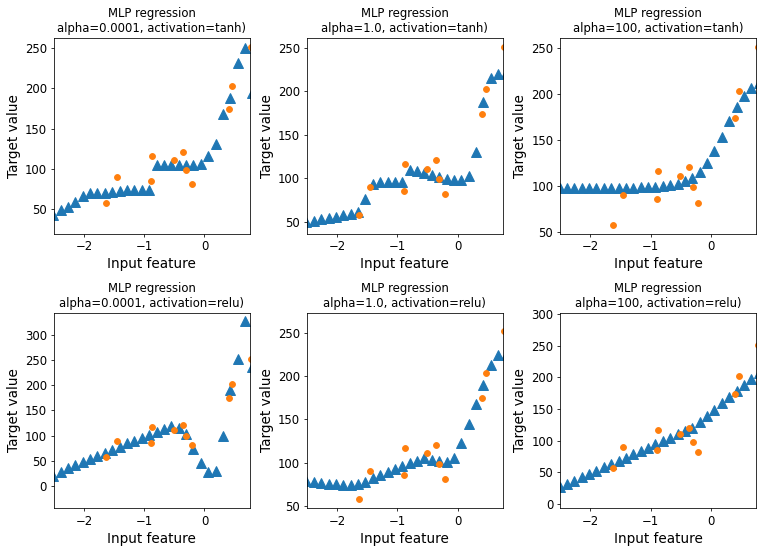

In [146]:
from sklearn.neural_network import MLPRegressor

fig, subaxes = plt.subplots(2, 3, figsize=(11,8), dpi=70)

X_predict_input = np.linspace(-3, 3, 50).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X_R1[0::5], y_R1[0::5], random_state = 0)

for thisaxisrow, thisactivation in zip(subaxes, ['tanh', 'relu']):
    for thisalpha, thisaxis in zip([0.0001, 1.0, 100], thisaxisrow):
        mlpreg = MLPRegressor(hidden_layer_sizes = [100,100],
                             activation = thisactivation,
                             alpha = thisalpha,
                             solver = 'lbfgs').fit(X_train, y_train)
        y_predict_output = mlpreg.predict(X_predict_input)
        thisaxis.set_xlim([-2.5, 0.75])
        thisaxis.plot(X_predict_input, y_predict_output,
                     '^', markersize = 10)
        thisaxis.plot(X_train, y_train, 'o')
        thisaxis.set_xlabel('Input feature')
        thisaxis.set_ylabel('Target value')
        thisaxis.set_title('MLP regression\nalpha={}, activation={})'
                          .format(thisalpha, thisactivation))
        plt.tight_layout()

## Part 1

### Application to real-world dataset for classification

1. Breast cancer dataset
   You might want to apply normalization. 

2. Fruit dataset

For each dataset, 

- apply neural network with 2 hidden layers with varying number of units (10, 20, 50, 100). 

- find out the optimla alpha parameter value for regularization. 

- apply different activation functions (logistic, tanh, relu) and show the effect.

- compare the results without scaling and with scaling. 


## Part 2

- Write a short summary of your analysis result of neural networks (submitted on Canvas). 

- Provide a link to the notebook on Github.

### 1. Breast Cancer dataset

In [147]:
# MLPclassifier
from sklearn.neural_network import MLPClassifier
from adspy_shared_utilities import plot_class_regions_for_classifier
from adspy_shared_utilities import plot_class_regions_for_classifier_subplot

#Load Breast Cancer dataset
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

# split the data
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

#fig, subaxes = plt.subplots(4, 1, figsize=(6, 23))

for units, axis in zip([10, 20, 50, 100], subaxes):
    
    # model training with two hidden layer
    nnclf =  MLPClassifier(hidden_layer_sizes = [units,units],
                           solver = 'lbfgs', random_state = 0).fit(X_train, y_train)
    
    #title = 'Dataset 1: Neural net classifier, 2 layer, {} units'.format(units)
    #plot_class_regions_for_classifier(nnclf, X_train, y_train,X_test, y_test, title, axis)
    #plt.tight_layout()

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### - find out the optimla alpha parameter value for regularization. 

In [148]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    y_pred = nnclf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(confusion_mat)
    
    target_names =['0', '1']
    result_metrics = classification_report(y_test, y_pred, target_names= target_names, output_dict=True)
    print('alpha ======>', this_alpha)
    print(result_metrics)
    print('accuracy: ', result_metrics['accuracy'])
    print('****************************************************************')
    
    

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[47  6]
 [ 7 83]]
alpha ======> 0.01
{'0': {'precision': 0.8703703703703703, 'recall': 0.8867924528301887, 'f1-score': 0.8785046728971964, 'support': 53}, '1': {'precision': 0.9325842696629213, 'recall': 0.9222222222222223, 'f1-score': 0.9273743016759777, 'support': 90}, 'accuracy': 0.9090909090909091, 'macro avg': {'precision': 0.9014773200166458, 'recall': 0.9045073375262055, 'f1-score': 0.902939487286587, 'support': 143}, 'weighted avg': {'precision': 0.909525971323724, 'recall': 0.9090909090909091, 'f1-score': 0.9092617819188069, 'support': 143}}
accuracy:  0.9090909090909091
****************************************************************
[[48  5]
 [ 8 82]]
alpha ======> 0.1
{'0': {'precision': 0.8571428571428571, 'recall': 0.9056603773584906, 'f1-score': 0.8807339449541285, 'support': 53}, '1': {'precision': 0.9425287356321839, 'recall': 0.9111111111111111, 'f1-score': 0.9265536723163842, 'support': 90}, 'accuracy': 0.9090909090909091, 'macro avg': {'precision': 0.89983579638752

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [149]:
for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    y_pred = nnclf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(confusion_mat)
    
    target_names =['0', '1']
    result_metrics = classification_report(y_test, y_pred, target_names= target_names, output_dict=True)
    print('alpha ======>', this_alpha)
    print(result_metrics)
    print('accuracy: ', result_metrics['accuracy'])
    print('****************************************************************')

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[50  3]
 [ 7 83]]
alpha ======> 0.01
{'0': {'precision': 0.8771929824561403, 'recall': 0.9433962264150944, 'f1-score': 0.9090909090909091, 'support': 53}, '1': {'precision': 0.9651162790697675, 'recall': 0.9222222222222223, 'f1-score': 0.9431818181818181, 'support': 90}, 'accuracy': 0.9300699300699301, 'macro avg': {'precision': 0.9211546307629539, 'recall': 0.9328092243186583, 'f1-score': 0.9261363636363635, 'support': 143}, 'weighted avg': {'precision': 0.9325293229821993, 'recall': 0.9300699300699301, 'f1-score': 0.9305467260012714, 'support': 143}}
accuracy:  0.9300699300699301
****************************************************************
[[50  3]
 [ 5 85]]
alpha ======> 0.1
{'0': {'precision': 0.9090909090909091, 'recall': 0.9433962264150944, 'f1-score': 0.9259259259259259, 'support': 53}, '1': {'precision': 0.9659090909090909, 'recall': 0.9444444444444444, 'f1-score': 0.9550561797752809, 'support': 90}, 'accuracy': 0.9440559440559441, 'macro avg': {'precision': 0.9375, 'recal

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [150]:
for this_alpha, axis in zip([0.01, 0.1, 1.0, 5.0], subaxes):
    nnclf = MLPClassifier(solver='lbfgs', activation = 'logistic',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    y_pred = nnclf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(confusion_mat)
    
    target_names =['0', '1']
    result_metrics = classification_report(y_test, y_pred, target_names= target_names, output_dict=True)
    print('alpha ======>', this_alpha)
    print(result_metrics)
    print('accuracy: ', result_metrics['accuracy'])
    print('****************************************************************')

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[45  8]
 [ 4 86]]
alpha ======> 0.01
{'0': {'precision': 0.9183673469387755, 'recall': 0.8490566037735849, 'f1-score': 0.8823529411764707, 'support': 53}, '1': {'precision': 0.9148936170212766, 'recall': 0.9555555555555556, 'f1-score': 0.9347826086956522, 'support': 90}, 'accuracy': 0.916083916083916, 'macro avg': {'precision': 0.9166304819800261, 'recall': 0.9023060796645703, 'f1-score': 0.9085677749360614, 'support': 143}, 'weighted avg': {'precision': 0.9161810833543357, 'recall': 0.916083916083916, 'f1-score': 0.9153506340207108, 'support': 143}}
accuracy:  0.916083916083916
****************************************************************
[[47  6]
 [ 9 81]]
alpha ======> 0.1
{'0': {'precision': 0.8392857142857143, 'recall': 0.8867924528301887, 'f1-score': 0.8623853211009174, 'support': 53}, '1': {'precision': 0.9310344827586207, 'recall': 0.9, 'f1-score': 0.9152542372881356, 'support': 90}, 'accuracy': 0.8951048951048951, 'macro avg': {'precision': 0.8851600985221675, 'recall': 0.

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### apply different activation functions (logistic, tanh, relu) and show the effect.

We applied this portion above where we tried to find the best alpha for logistic, tanh, and relu. Relu had the best accuracy score. 

### compare the results without scaling and with scaling. 

With Scaling

In [151]:
#Testing

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X_scaled_training = scaler.fit_transform(X_train)
X_scaled_testing = scaler.fit_transform(X_test)

#Testing
print('testing **********************************************')
nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = 0.1,
                         hidden_layer_sizes = [100, 100],

                      random_state = 0).fit(X_scaled_training, y_train)
y_pred = nnclf.predict(X_scaled_testing)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

target_names =['0', '1']
result_metrics = classification_report(y_test, y_pred, target_names= target_names, output_dict=True)
print(result_metrics)
print('accuracy: ', result_metrics['accuracy'])

#Training
print('\n training *********************************************')
nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],

                      random_state = 0).fit(X_scaled_training, y_train)
y_pred = nnclf.predict(X_scaled_training)
confusion_mat = confusion_matrix(y_train, y_pred)
print(confusion_mat)

target_names =['0', '1']
result_metrics = classification_report(y_train, y_pred, target_names= target_names, output_dict=True)
print(result_metrics)
print('accuracy: ', result_metrics['accuracy'])



testing **********************************************


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[53  0]
 [34 56]]
{'0': {'precision': 0.6091954022988506, 'recall': 1.0, 'f1-score': 0.7571428571428571, 'support': 53}, '1': {'precision': 1.0, 'recall': 0.6222222222222222, 'f1-score': 0.7671232876712328, 'support': 90}, 'accuracy': 0.7622377622377622, 'macro avg': {'precision': 0.8045977011494253, 'recall': 0.8111111111111111, 'f1-score': 0.762133072407045, 'support': 143}, 'weighted avg': {'precision': 0.8551563379149586, 'recall': 0.7622377622377622, 'f1-score': 0.7634242469858908, 'support': 143}}
accuracy:  0.7622377622377622

 training *********************************************
[[159   0]
 [  0 267]]
{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 159}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 267}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 426}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 426}}
accuracy:  1.0


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [152]:
#Testing

#Testing
print('testing **********************************************')
nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = 0.1,
                         hidden_layer_sizes = [100, 100],

                      random_state = 0).fit(X_train, y_train)
y_pred = nnclf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

target_names =['0', '1']
result_metrics = classification_report(y_test, y_pred, target_names= target_names, output_dict=True)
print(result_metrics)
print('accuracy: ', result_metrics['accuracy'])

#Training
print('\n training *********************************************')
nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],

                      random_state = 0).fit(X_train, y_train)
y_pred = nnclf.predict(X_train)
confusion_mat = confusion_matrix(y_train, y_pred)
print(confusion_mat)

target_names =['0', '1']
result_metrics = classification_report(y_train, y_pred, target_names= target_names, output_dict=True)
print(result_metrics)
print('accuracy: ', result_metrics['accuracy'])

testing **********************************************


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[50  3]
 [ 5 85]]
{'0': {'precision': 0.9090909090909091, 'recall': 0.9433962264150944, 'f1-score': 0.9259259259259259, 'support': 53}, '1': {'precision': 0.9659090909090909, 'recall': 0.9444444444444444, 'f1-score': 0.9550561797752809, 'support': 90}, 'accuracy': 0.9440559440559441, 'macro avg': {'precision': 0.9375, 'recall': 0.9439203354297694, 'f1-score': 0.9404910528506034, 'support': 143}, 'weighted avg': {'precision': 0.9448506039415131, 'recall': 0.9440559440559441, 'f1-score': 0.9442596521248207, 'support': 143}}
accuracy:  0.9440559440559441

 training *********************************************
[[149  10]
 [  6 261]]
{'0': {'precision': 0.9612903225806452, 'recall': 0.9371069182389937, 'f1-score': 0.9490445859872612, 'support': 159}, '1': {'precision': 0.9630996309963099, 'recall': 0.9775280898876404, 'f1-score': 0.970260223048327, 'support': 267}, 'accuracy': 0.9624413145539906, 'macro avg': {'precision': 0.9621949767884775, 'recall': 0.9573175040633171, 'f1-score': 0.95

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### 2. Fruit dataset

In [153]:
fruits = pd.read_table('./data/fruit_data_with_colors.txt')

feature_names_fruits = ['height', 'width', 'mass', 'color_score']
X_fruits = fruits[feature_names_fruits]
y_fruits = fruits['fruit_label']
target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

X_train, X_test, y_train, y_test = train_test_split(X_fruits, y_fruits, random_state=0)

for units, axis in zip([10, 20, 50, 100], subaxes):
    
    # model training with one hidden layer
    nnclf =  MLPClassifier(hidden_layer_sizes = [units,units], solver = 'lbfgs', random_state = 0).fit(X_train, y_train)

    title = 'Dataset 1: Neural net classifier, 2 layer, {} units'.format(units)

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [154]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

for this_alpha in [0.01, 0.1, 1.0, 5.0]:
    nnclf = MLPClassifier(solver='lbfgs', activation = 'tanh',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    y_pred = nnclf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(confusion_mat)
    
    result_metrics = classification_report(y_test, y_pred, target_names= target_names_fruits, output_dict=True)
    print('alpha ======>', this_alpha)
    print(result_metrics)
    print('accuracy: ', result_metrics['accuracy'])
    print('****************************************************************')
    

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[2 0 2 0]
 [0 1 0 0]
 [2 0 4 2]
 [0 0 0 2]]
alpha ======> 0.01
{'apple': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 4}, 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 'orange': {'precision': 0.6666666666666666, 'recall': 0.5, 'f1-score': 0.5714285714285715, 'support': 8}, 'lemon': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 2}, 'accuracy': 0.6, 'macro avg': {'precision': 0.6666666666666666, 'recall': 0.75, 'f1-score': 0.6845238095238095, 'support': 15}, 'weighted avg': {'precision': 0.6222222222222221, 'recall': 0.6, 'f1-score': 0.5936507936507937, 'support': 15}}
accuracy:  0.6
****************************************************************


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[2 0 2 0]
 [0 1 0 0]
 [0 1 7 0]
 [0 0 0 2]]
alpha ======> 0.1
{'apple': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 4}, 'mandarin': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 1}, 'orange': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.823529411764706, 'support': 8}, 'lemon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'accuracy': 0.8, 'macro avg': {'precision': 0.8194444444444444, 'recall': 0.84375, 'f1-score': 0.7892156862745098, 'support': 15}, 'weighted avg': {'precision': 0.8481481481481481, 'recall': 0.8, 'f1-score': 0.7947712418300654, 'support': 15}}
accuracy:  0.8
****************************************************************


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[4 0 0 0]
 [0 1 0 0]
 [5 1 2 0]
 [0 0 0 2]]
alpha ======> 1.0
{'apple': {'precision': 0.4444444444444444, 'recall': 1.0, 'f1-score': 0.6153846153846153, 'support': 4}, 'mandarin': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 1}, 'orange': {'precision': 1.0, 'recall': 0.25, 'f1-score': 0.4, 'support': 8}, 'lemon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'accuracy': 0.6, 'macro avg': {'precision': 0.7361111111111112, 'recall': 0.8125, 'f1-score': 0.6705128205128205, 'support': 15}, 'weighted avg': {'precision': 0.8185185185185185, 'recall': 0.6, 'f1-score': 0.5552136752136752, 'support': 15}}
accuracy:  0.6
****************************************************************
[[4 0 0 0]
 [0 0 0 1]
 [5 0 1 2]
 [1 0 0 1]]
alpha ======> 5.0
{'apple': {'precision': 0.4, 'recall': 1.0, 'f1-score': 0.5714285714285715, 'support': 4}, 'mandarin': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'orange': {'precision': 1.0, 'r

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [155]:
for this_alpha in [0.01, 0.1, 1.0, 5.0]:
    nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    y_pred = nnclf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(confusion_mat)
    
    target_names =['0', '1']
    result_metrics = classification_report(y_test, y_pred, target_names= target_names_fruits, output_dict=True)
    print('alpha ======>', this_alpha)
    print(result_metrics)
    print('accuracy: ', result_metrics['accuracy'])
    print('****************************************************************')

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[4 0 0 0]
 [0 1 0 0]
 [0 0 6 2]
 [0 0 0 2]]
alpha ======> 0.01
{'apple': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4}, 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 'orange': {'precision': 1.0, 'recall': 0.75, 'f1-score': 0.8571428571428571, 'support': 8}, 'lemon': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 2}, 'accuracy': 0.8666666666666667, 'macro avg': {'precision': 0.875, 'recall': 0.9375, 'f1-score': 0.8809523809523809, 'support': 15}, 'weighted avg': {'precision': 0.9333333333333333, 'recall': 0.8666666666666667, 'f1-score': 0.8793650793650795, 'support': 15}}
accuracy:  0.8666666666666667
****************************************************************


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[2 0 2 0]
 [0 1 0 0]
 [2 0 6 0]
 [0 0 0 2]]
alpha ======> 0.1
{'apple': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 4}, 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 'orange': {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 8}, 'lemon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'accuracy': 0.7333333333333333, 'macro avg': {'precision': 0.8125, 'recall': 0.8125, 'f1-score': 0.8125, 'support': 15}, 'weighted avg': {'precision': 0.7333333333333333, 'recall': 0.7333333333333333, 'f1-score': 0.7333333333333333, 'support': 15}}
accuracy:  0.7333333333333333
****************************************************************


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[2 0 2 0]
 [0 1 0 0]
 [0 0 6 2]
 [0 0 1 1]]
alpha ======> 1.0
{'apple': {'precision': 1.0, 'recall': 0.5, 'f1-score': 0.6666666666666666, 'support': 4}, 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 'orange': {'precision': 0.6666666666666666, 'recall': 0.75, 'f1-score': 0.7058823529411765, 'support': 8}, 'lemon': {'precision': 0.3333333333333333, 'recall': 0.5, 'f1-score': 0.4, 'support': 2}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.75, 'recall': 0.6875, 'f1-score': 0.6931372549019608, 'support': 15}, 'weighted avg': {'precision': 0.7333333333333332, 'recall': 0.6666666666666666, 'f1-score': 0.674248366013072, 'support': 15}}
accuracy:  0.6666666666666666
****************************************************************
[[4 0 0 0]
 [0 0 1 0]
 [8 0 0 0]
 [0 0 0 2]]
alpha ======> 5.0
{'apple': {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 4}, 'mandarin': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, '

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [156]:
for this_alpha in [0.01, 0.1, 1.0, 5.0]:
    nnclf = MLPClassifier(solver='lbfgs', activation = 'logistic',
                         alpha = this_alpha,
                         hidden_layer_sizes = [100, 100],
                         random_state = 0).fit(X_train, y_train)
    y_pred = nnclf.predict(X_test)
    confusion_mat = confusion_matrix(y_test, y_pred)
    print(confusion_mat)
    
    target_names =['0', '1']
    result_metrics = classification_report(y_test, y_pred, target_names= target_names_fruits, output_dict=True)
    print('alpha ======>', this_alpha)
    print(result_metrics)
    print('accuracy: ', result_metrics['accuracy'])
    print('****************************************************************')

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[2 0 2 0]
 [0 1 0 0]
 [1 0 7 0]
 [0 0 0 2]]
alpha ======> 0.01
{'apple': {'precision': 0.6666666666666666, 'recall': 0.5, 'f1-score': 0.5714285714285715, 'support': 4}, 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 'orange': {'precision': 0.7777777777777778, 'recall': 0.875, 'f1-score': 0.823529411764706, 'support': 8}, 'lemon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'accuracy': 0.8, 'macro avg': {'precision': 0.861111111111111, 'recall': 0.84375, 'f1-score': 0.8487394957983194, 'support': 15}, 'weighted avg': {'precision': 0.7925925925925926, 'recall': 0.8, 'f1-score': 0.7915966386554623, 'support': 15}}
accuracy:  0.8
****************************************************************


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[4 0 0 0]
 [0 1 0 0]
 [6 1 1 0]
 [0 0 0 2]]
alpha ======> 0.1
{'apple': {'precision': 0.4, 'recall': 1.0, 'f1-score': 0.5714285714285715, 'support': 4}, 'mandarin': {'precision': 0.5, 'recall': 1.0, 'f1-score': 0.6666666666666666, 'support': 1}, 'orange': {'precision': 1.0, 'recall': 0.125, 'f1-score': 0.2222222222222222, 'support': 8}, 'lemon': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2}, 'accuracy': 0.5333333333333333, 'macro avg': {'precision': 0.725, 'recall': 0.78125, 'f1-score': 0.6150793650793651, 'support': 15}, 'weighted avg': {'precision': 0.8066666666666666, 'recall': 0.5333333333333333, 'f1-score': 0.4486772486772487, 'support': 15}}
accuracy:  0.5333333333333333
****************************************************************
[[4 0 0 0]
 [0 0 0 1]
 [5 0 1 2]
 [1 0 0 1]]
alpha ======> 1.0
{'apple': {'precision': 0.4, 'recall': 1.0, 'f1-score': 0.5714285714285715, 'support': 4}, 'mandarin': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pedro\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(a

### With scaling

In [157]:
#Testing

target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
X_scaled_training = scaler.fit_transform(X_train)
X_scaled_testing = scaler.fit_transform(X_test)

#Testing
print('testing **********************************************')
nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = 0.01,
                         hidden_layer_sizes = [100, 100],

                      random_state = 0).fit(X_scaled_training, y_train)
y_pred = nnclf.predict(X_scaled_testing)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

result_metrics = classification_report(y_test, y_pred, target_names= target_names_fruits, output_dict=True)
print(result_metrics)
print('accuracy: ', result_metrics['accuracy'])

#Training
print('\n training *********************************************')
nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = 0.01,
                         hidden_layer_sizes = [100, 100],

                      random_state = 0).fit(X_scaled_training, y_train)
y_pred = nnclf.predict(X_scaled_training)
confusion_mat = confusion_matrix(y_train, y_pred)
print(confusion_mat)

result_metrics = classification_report(y_train, y_pred, target_names= target_names_fruits, output_dict=True)
print(result_metrics)
print('accuracy: ', result_metrics['accuracy'])

testing **********************************************


C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[[3 0 0 1]
 [0 1 0 0]
 [2 0 3 3]
 [0 0 0 2]]
{'apple': {'precision': 0.6, 'recall': 0.75, 'f1-score': 0.6666666666666665, 'support': 4}, 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 1}, 'orange': {'precision': 1.0, 'recall': 0.375, 'f1-score': 0.5454545454545454, 'support': 8}, 'lemon': {'precision': 0.3333333333333333, 'recall': 1.0, 'f1-score': 0.5, 'support': 2}, 'accuracy': 0.6, 'macro avg': {'precision': 0.7333333333333334, 'recall': 0.78125, 'f1-score': 0.678030303030303, 'support': 15}, 'weighted avg': {'precision': 0.8044444444444444, 'recall': 0.6, 'f1-score': 0.602020202020202, 'support': 15}}
accuracy:  0.6

 training *********************************************
[[15  0  0  0]
 [ 0  4  0  0]
 [ 0  0 11  0]
 [ 0  0  0 14]]
{'apple': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 15}, 'mandarin': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 4}, 'orange': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 

C:\Users\pedro\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Without Scaling

In [ ]:
#Testing

target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']

#Testing
print('testing **********************************************')
nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = 0.01,
                         hidden_layer_sizes = [100, 100],

                      random_state = 0).fit(X_train, y_train)
y_pred = nnclf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)

result_metrics = classification_report(y_test, y_pred, target_names= target_names_fruits, output_dict=True)
print(result_metrics)
print('accuracy: ', result_metrics['accuracy'])

#Training
print('\n training *********************************************')
nnclf = MLPClassifier(solver='lbfgs', activation = 'relu',
                         alpha = 0.01,
                         hidden_layer_sizes = [100, 100],

                      random_state = 0).fit(X_scaled_training, y_train)
y_pred = nnclf.predict(X_scaled_training)
confusion_mat = confusion_matrix(y_train, y_pred)
print(confusion_mat)

result_metrics = classification_report(y_train, y_pred, target_names= target_names_fruits, output_dict=True)
print(result_metrics)
print('accuracy: ', result_metrics['accuracy'])

#### Cells of your analysis will be added below.